# Geolocating NetCDF
Be able to get lat/lon from NetCDF in polar stereographic format.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [70]:
from pyproj import Proj, transform

# Define the projection using the Proj4 string
proj = Proj(
    "+proj=stere +lat_0=90 +lat_ts=60 +lon_0=-80 +k=1 +x_0=0 +y_0=0 +a=6378137 +b=6356257 +units=m +no_defs"
)

# Example coordinates (longitude, latitude)
lon, lat = -80, 60

# Convert geographic coordinates to projection coordinates (x, y)
x, y = proj(lon, lat)

print(f"Projected coordinates: x={x}, y={y}")

# To go the other way, from projection coordinates to geographic coordinates:
lon, lat = proj(x, y, inverse=True)
print(f"Geographic coordinates: lon={lon}, lat={lat}")

Projected coordinates: x=0.0, y=-3197291.119035255
Geographic coordinates: lon=-80.0, lat=59.999999999998494


In [40]:
def plot_sie(sie: np.array):
    colors = ["#E500E5", "#0066FF", "#01FF00", "#FFC100", "#E50000"]
    cmap = ListedColormap(colors, name="custom_colormap", N=len(colors))

    # Plotting the sea ice extent with the custom colormap
    plt.figure(figsize=(10, 10))
    plt.imshow(sie, cmap=cmap, vmin=0, vmax=len(colors) - 1)
    plt.title("Sea Ice Extent around the Arctic Circle", fontsize=12)
    plt.axis("off")

    # Adding a colorbar with labels for different surface types
    cbar = plt.colorbar(ticks=range(len(colors)))
    cbar.ax.set_yticklabels(
        [
            "Outside Northern Hemisphere",
            "Open Water",
            "Land without Snow",
            "Sea or Lake Ice",
            "Snow Covered Land",
        ]
    )
    cbar.set_label("Surface Type")

    plt.show()

In [67]:
import numpy as np


def polarstereo_fwd(
    phi, lambda_, a=6378137, f=291.505347349177, phi_c=60, lambda_0=-80
):
    """
    Transforms lat/lon data to map coordinates for a polar stereographic system.

    Parameters:
    - phi (float or array-like): Latitude in decimal degrees. Negative for S.
    - lambda_ (float or array-like): Longitude in decimal degrees. Negative for W.
    - a (float): Earth radius in meters.
    - f (float): Flattening of the ellipsoid.
    - phi_c (float): Latitude of true scale in degrees.
    - lambda_0 (float): Meridian along the positive Y axis of the map in degrees.

    Returns:
    - x (float or array-like): X map coordinates.
    - y (float or array-like): Y map coordinates.
    """
    e = np.sqrt(2 / f - 1 / f**2)  # Calculate eccentricity from flattening
    phi = np.radians(phi)
    phi_c = np.radians(phi_c)
    lambda_ = np.radians(lambda_)
    lambda_0 = np.radians(lambda_0)

    t = np.tan(np.pi / 4 - phi / 2) / (
        (1 - e * np.sin(phi)) / (1 + e * np.sin(phi))
    ) ** (e / 2)
    t_c = np.tan(np.pi / 4 - phi_c / 2) / (
        (1 - e * np.sin(phi_c)) / (1 + e * np.sin(phi_c))
    ) ** (e / 2)
    m_c = np.cos(phi_c) / np.sqrt(1 - e**2 * np.sin(phi_c) ** 2)
    rho = a * m_c * t / t_c
    m = np.cos(phi) / np.sqrt(1 - e**2 * np.sin(phi) ** 2)

    x = rho * np.sin(lambda_ - lambda_0)
    y = -rho * np.cos(lambda_ - lambda_0)

    return x, y


# Example usage:
phi = 75  # Latitude
lambda_ = -45  # Longitude
x, y = polarstereo_fwd(phi, lambda_)
print(x, y)

901672.8884903947 -1287722.338430962


In [68]:
import numpy as np


def polarstereo_inv(
    x,
    y,
    a=6378137,
    e=np.sqrt(2 / 291.505347349177 - 1 / 291.505347349177**2),
    phi_c=60,
    lambda_0=-80,
):
    """
    Transforms map coordinates to lat/lon for a polar stereographic system using the IMS v3 Projection parameters.

    Parameters:
    - x, y: Map coordinates (scalars, vectors, or matrices of equal size).

    Constants for IMS v3 Projection:
    - a: Earth radius in meters (6378137 for WGS84).
    - e: Earth eccentricity derived from flattening.
    - phi_c: Latitude of true scale in degrees (60 for IMS v3).
    - lambda_0: Meridian along the positive Y axis of the map in degrees (-80 for IMS v3).

    Returns:
    - phi: Latitude in decimal degrees.
    - lambda: Longitude in decimal degrees.
    """

    # Convert degrees to radians
    phi_c = np.radians(phi_c)
    lambda_0 = np.radians(lambda_0)

    # Compute constants
    t_c = np.tan(np.pi / 4 - phi_c / 2) / (
        (1 - e * np.sin(phi_c)) / (1 + e * np.sin(phi_c))
    ) ** (e / 2)
    m_c = np.cos(phi_c) / np.sqrt(1 - e**2 * np.sin(phi_c) ** 2)
    rho = np.sqrt(x**2 + y**2)
    t = rho * t_c / (a * m_c)

    # Compute latitude using the series expansion
    chi = np.pi / 2 - 2 * np.arctan(t)
    phi = (
        chi
        + (e**2 / 2 + 5 * e**4 / 24 + e**6 / 12 + 13 * e**8 / 360)
        * np.sin(2 * chi)
        + (7 * e**4 / 48 + 29 * e**6 / 240 + 811 * e**8 / 11520) * np.sin(4 * chi)
        + (7 * e**6 / 120 + 81 * e**8 / 1120) * np.sin(6 * chi)
        + (4279 * e**8 / 161280) * np.sin(8 * chi)
    )

    # Compute longitude
    lambda_ = lambda_0 + np.arctan2(x, -y)

    # Adjust signs and ranges
    phi = np.degrees(phi)
    lambda_ = np.degrees(lambda_)
    lambda_ = (lambda_ + 180) % 360 - 180  # Normalize to [-180, 180]

    return phi, lambda_


# Example usage
# Assuming x, y are the map coordinates for which you want to find the latitude and longitude.
x = -1540033.6
y = -560526.4
phi, lambda_ = polarstereo_inv(x, y)
print(f"Latitude: {phi}, Longitude: {lambda_}")

Latitude: 74.36953341258877, Longitude: -149.99999967705736


In [57]:
def polarstereo_inv(x, y):
    """
    Transforms map coordinates to lat/lon for a polar stereographic system.

    Parameters:
    - x, y: Map coordinates (scalars, vectors, or matrices of equal size).

    Constants:
    - a: Earth radius in meters (default is 6378137.0 for WGS84).
    - e: Earth eccentricity (default is 0.08181919 for WGS84).
    - phi_c: Latitude of true scale in degrees (default is -70).
    - lambda_0: Meridian along the positive Y axis of the map in degrees (default is 0).

    Returns:
    - phi: Latitude in decimal degrees.
    - lambda: Longitude in decimal degrees.
    """
    a = 6378137.0
    e = 0.08181919
    phi_c = -70
    lambda_0 = 0

    # Convert degrees to radians
    phi_c = np.radians(phi_c)
    lambda_0 = np.radians(lambda_0)

    # Determine hemisphere based on phi_c
    pm = -1 if phi_c < 0 else 1
    if pm < 0:
        phi_c = -phi_c
        lambda_0 = -lambda_0
        x, y = -x, -y
        print(x, y)

    # Compute constants
    t_c = np.tan(np.pi / 4 - phi_c / 2) / (
        (1 - e * np.sin(phi_c)) / (1 + e * np.sin(phi_c))
    ) ** (e / 2)
    m_c = np.cos(phi_c) / np.sqrt(1 - e**2 * np.sin(phi_c) ** 2)
    rho = np.sqrt(x**2 + y**2)
    t = rho * t_c / (a * m_c)

    # Compute latitude using the series expansion
    chi = np.pi / 2 - 2 * np.arctan(t)
    phi = (
        chi
        + (e**2 / 2 + 5 * e**4 / 24 + e**6 / 12 + 13 * e**8 / 360)
        * np.sin(2 * chi)
        + (7 * e**4 / 48 + 29 * e**6 / 240 + 811 * e**8 / 11520) * np.sin(4 * chi)
        + (7 * e**6 / 120 + 81 * e**8 / 1120) * np.sin(6 * chi)
        + (4279 * e**8 / 161280) * np.sin(8 * chi)
    )

    # Compute longitude
    lambda_ = lambda_0 + np.arctan2(x, -y)

    # Adjust signs and ranges
    phi = pm * np.degrees(phi)
    lambda_ = pm * np.degrees(lambda_)
    lambda_ = (lambda_ + 180) % 360 - 180  # Normalize to [-180, 180]

    return phi, lambda_

In [59]:
def polarstereo_fwd(phi, lambda_):
    """
    Transforms lat/lon data to map coordinates for a polar stereographic system.

    Parameters:
    - phi (float or array-like): Latitude in decimal degrees. Negative for S.
    - lambda_ (float or array-like): Longitude in decimal degrees. Negative for W.

    Constants:
    - a (float): Earth radius in meters (default is 6378137.0 for WGS84).
    - e (float): Earth eccentricity (default is 0.08181919 for WGS84).
    - phi_c (float): Latitude of true scale in degrees (default is -70).
    - lambda_0 (float): Meridian along the positive Y axis of the map in degrees (default is 0).

    Returns:
    - x (float or array-like): X map coordinates.
    - y (float or array-like): Y map coordinates.
    """
    a = 6378137.0
    e = 0.08181919
    phi_c = -70
    lambda_0 = 0

    # Convert to radians
    phi = np.radians(phi)
    phi_c = np.radians(phi_c)
    lambda_ = np.radians(lambda_)
    lambda_0 = np.radians(lambda_0)

    # If the standard parallel is in the Southern Hemisphere, switch signs
    pm = -1 if phi_c < 0 else 1
    if pm < 0:
        phi = -phi
        phi_c = -phi_c
        lambda_ = -lambda_
        lambda_0 = -lambda_0

    # Calculate terms
    t = np.tan(np.pi / 4 - phi / 2) / (
        (1 - e * np.sin(phi)) / (1 + e * np.sin(phi))
    ) ** (e / 2)
    t_c = np.tan(np.pi / 4 - phi_c / 2) / (
        (1 - e * np.sin(phi_c)) / (1 + e * np.sin(phi_c))
    ) ** (e / 2)
    m_c = np.cos(phi_c) / np.sqrt(1 - e**2 * np.sin(phi_c) ** 2)
    rho = a * m_c * t / t_c
    m = np.cos(phi) / np.sqrt(1 - e**2 * np.sin(phi) ** 2)

    # Calculate coordinates
    x = pm * rho * np.sin(lambda_ - lambda_0)
    y = -pm * rho * np.cos(lambda_ - lambda_0)

    return x, y


# Example usage:
phi = -75  # Latitude
lambda_ = 150  # Longitude
x, y = polarstereo_fwd(phi, lambda_)
print(x, y)

816939.7486823716 -1414981.1514404176


In [60]:
x, y = polarstereo_fwd(phi, lambda_)
print(polarstereo_inv(x, y))

-816939.7486823716 1414981.1514404176
(-74.99999999999771, 150.0)


## Load a sample netCDF file

In [46]:
file_path = "../../data/netcdf/2024/masie_all_r00_v01_2024016_1km.nc"  # masie_all_r00_v01_2023364_1km.nc'
file_path = "/home/bacon/Downloads/ims2023015_1km_v1.3.nc"
with h5py.File(file_path, "r") as file:
    keys = list(file.keys())
    attributes = dict(file.attrs)

# keys, attributes

In [47]:
keys

['IMS_Surface_Values', 'projection', 'time', 'x', 'y']

In [71]:
with h5py.File(file_path, "r") as file:
    # sie = file["sea_ice_extent"][:]
    sie = file["IMS_Surface_Values"][:]
    x_coords = file["x"][:]
    y_coords = file["y"][:]

In [72]:
x_coords

array([-12287500., -12286500., -12285500., ...,  12285500.,  12286500.,
        12287500.], dtype=float32)

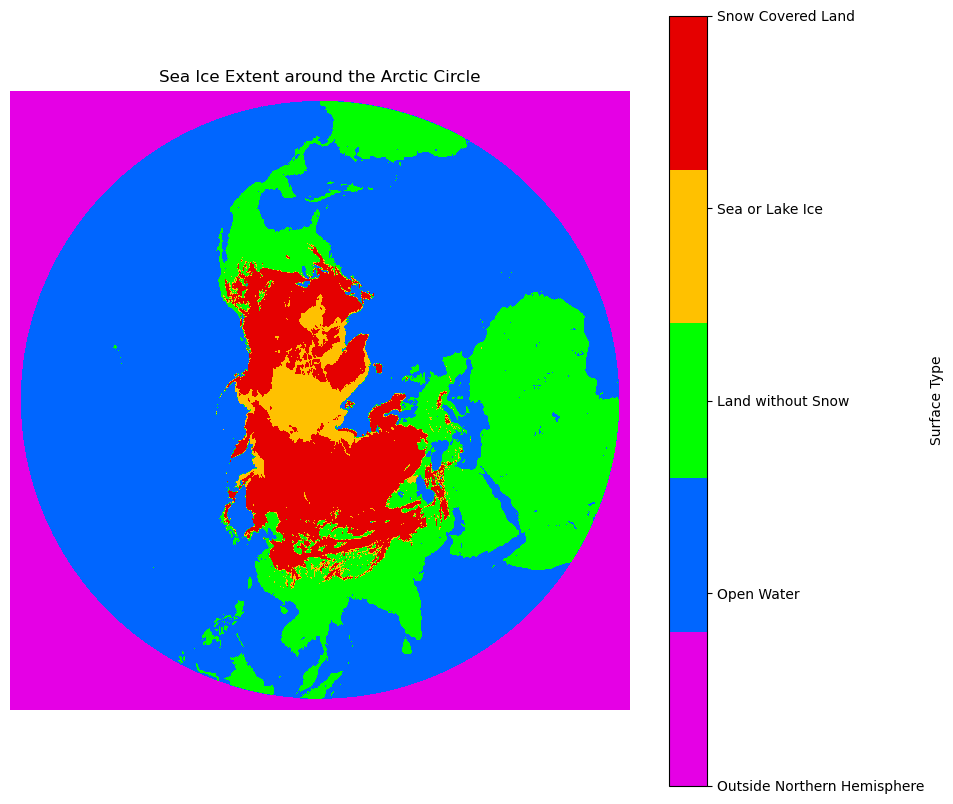

In [52]:
plot_sie(sie[0])

In [53]:
np.where(np.isclose(x, 3750000.0))
np.where(np.isclose(y, -5350000.0))

(array([], dtype=int64),)

In [54]:
x[0], y[0]

(-12287500.0, -12287500.0)

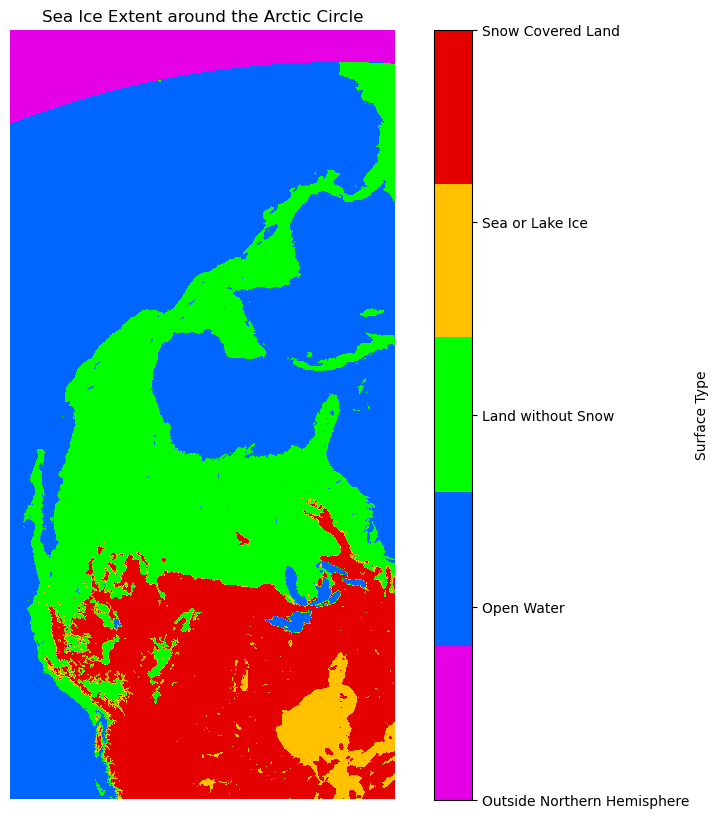

In [66]:
plot_sie(sie[0, 0:10000, 8000:13000])

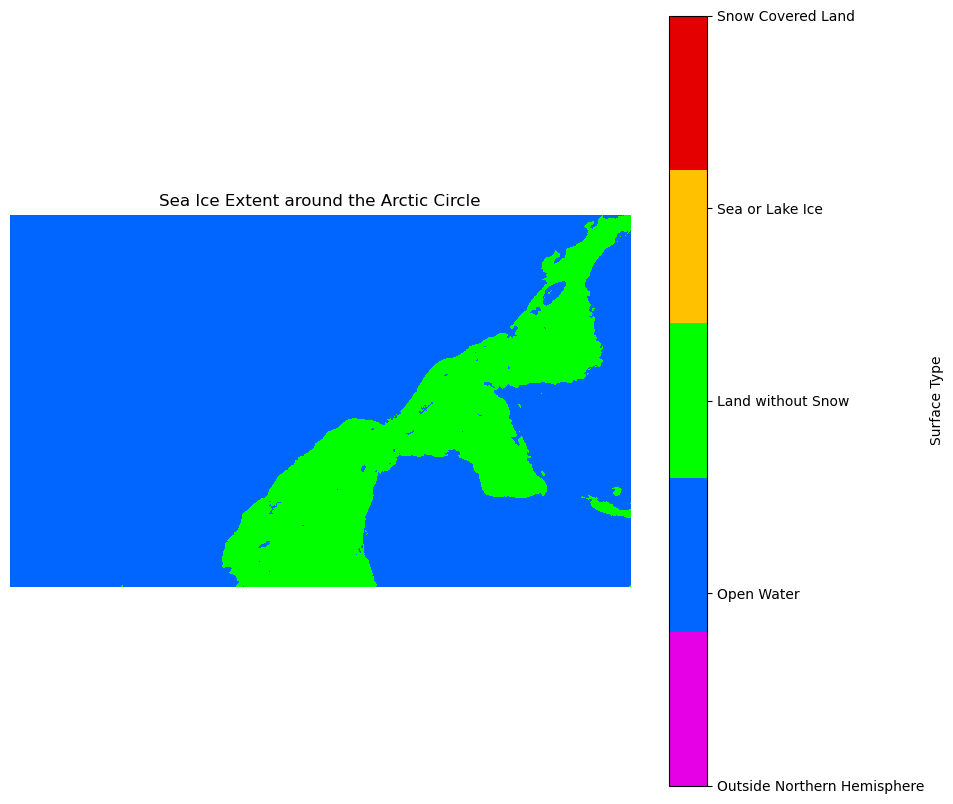

In [64]:
plot_sie(sie[0, 2000:5000, 7000:12000])

### Testing X, Y Polar Sterographic to Lat Lon

In [69]:
# Define a list of test cases with x, y in meters, and the expected latitude and longitude
test_cases = [
    (-3850000, 5850000, 30.98, 168.35, "upper left corner"),
    (0, 5850000, 39.43, 135.00, "top midpoint"),
    (3750000, 5850000, 31.37, 102.34, "upper right corner"),
    (3750000, 0, 56.35, 45.00, "right side midpoint"),
    (
        3750000,
        -5350000,
        34.35,
        -9.97,
        "lower right corner",
    ),  # Adjusted longitude for consistency
    (0, -5350000, 43.28, -45.00, "bottom midpoint"),
    (
        -3850000,
        -5350000,
        33.92,
        -80.74,
        "lower left corner",
    ),  # Adjusted longitude for consistency
    (
        -3850000,
        0,
        55.50,
        -135.00,
        "left side midpoint",
    ),  # Adjusted longitude for consistency
]

# Tolerance for floating point comparison
tolerance = 0.1

# Execute tests
for x, y, expected_lat, expected_lon, description in test_cases:
    lat, lon = polarstereo_inv(x, y)
    assert (
        abs(lat - expected_lat) < tolerance and abs(lon - expected_lon) < tolerance
    ), f"Test failed for {description}: Expected ({expected_lat}, {expected_lon}), got ({lat}, {lon})"

print("All tests passed!")

AssertionError: Test failed for upper left corner: Expected (30.98, 168.35), got (29.05140198016557, 133.34970056246232)